# Prism alignment

The goal of this notebook is to prototype a method for aligning prisms to the principal axes of the matrix.

While I have a method that works in some cases, it appears to be extremely sensitive and I'm not sure why.

## Imports

In [1]:
import napari
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import affine_transform
from scipy.spatial.transform import Rotation as R
from skimage import measure

Show package versions for reproducibility:

In [2]:
!pip index versions matplotlib
!pip index versions napari
!pip index versions numpy
!pip index versions scipy
!pip index versions scikit-image

matplotlib (3.7.2)
Available versions: 3.7.2, 3.7.1, 3.7.0, 3.6.3, 3.6.2, 3.6.1, 3.6.0, 3.5.3, 3.5.2, 3.5.1, 3.5.0, 3.4.3, 3.4.2, 3.4.1, 3.4.0, 3.3.4, 3.3.3, 3.3.2, 3.3.1, 3.3.0, 3.2.2, 3.2.1, 3.2.0, 3.1.3, 3.1.2, 3.1.1, 3.1.0, 3.0.3, 3.0.2, 3.0.1, 3.0.0, 2.2.5, 2.2.4, 2.2.3, 2.2.2, 2.2.0, 2.1.2, 2.1.1, 2.1.0, 2.0.2, 2.0.1, 2.0.0, 1.5.3, 1.5.2, 1.5.1, 1.5.0, 1.4.3, 1.4.2, 1.4.1, 1.4.0, 1.3.1, 1.3.0, 1.2.1, 1.2.0, 1.1.1, 1.1.0, 1.0.1, 0.91.1, 0.91.0, 0.86.2, 0.86.1, 0.86
  INSTALLED: 3.7.2
  LATEST:    3.7.2
napari (0.4.18)
Available versions: 0.4.18, 0.4.17, 0.4.16, 0.4.15, 0.4.14, 0.4.13, 0.4.12, 0.4.11, 0.4.10, 0.4.9, 0.4.8, 0.4.7, 0.4.6, 0.4.5, 0.4.4, 0.4.3, 0.4.2, 0.4.1, 0.4.0, 0.3.8, 0.3.7, 0.3.6, 0.3.5, 0.3.4, 0.3.3, 0.3.2, 0.3.1, 0.3.0, 0.2.12, 0.2.11, 0.2.10, 0.2.9, 0.2.8, 0.2.7, 0.2.6, 0.2.5, 0.2.4, 0.2.3, 0.2.2, 0.2.1, 0.2.0, 0.1.5, 0.1.4, 0.1.3, 0.1.2, 0.1.1, 0.1.0, 0.0.9, 0.0.8, 0.0.7, 0.0.6
  INSTALLED: 0.4.17
  LATEST:    0.4.18
numpy (1.25.2)
Available versions: 1.25.2, 

# Code

## Helper functions for visualization

First, create some helper functions for easy visualization.

`wannabe_napari` is a quick 'n dirty function to visualize three central slices from an array.

In [3]:
def wannabe_napari(array):
    fig, axes = plt.subplots(figsize=(10, 10), nrows=1, ncols=3)

    for k, axis in enumerate(axes):
        axis_slice = np.take(array, indices=array.shape[k] // 2, axis=k)
        axis.imshow(
            axis_slice, cmap="gray", vmin=0, vmax=1 if array.max() == 1 else 255
        )
        axis.set_title(f"axis={k}")


`view_napari` is a simple wrapper for `napari.view_image`. `napari` can be difficult to install, so these views are optional (currently commented out).

In [4]:
def view_napari(array, title):
    napari.view_image(array, rgb=False, colormap="gray", title=title)

## Generate synthetic data

First, create a **binary** synthetic rectangular prism:

In [5]:
def create_rectangular_prism_binary(lengths, offsets, grid_size):
    # Initialize a grid with a zero background
    grid = np.zeros((grid_size[0], grid_size[1], grid_size[2]), dtype=np.uint8)

    # Define the starting point
    x_start, y_start, z_start = offsets

    # Fill in the grid cells corresponding to the rectangular prism with 1
    x_len, y_len, z_len = lengths
    grid[
        x_start : x_start + x_len, y_start : y_start + y_len, z_start : z_start + z_len
    ] = 1

    return grid


lengths = (15, 50, 30)
offsets = np.array((8, -6, 13)) + np.array((20, 20, 20))
grid_size = np.asarray((70, 70, 70))

data_binary = create_rectangular_prism_binary(lengths, offsets, grid_size)


View:

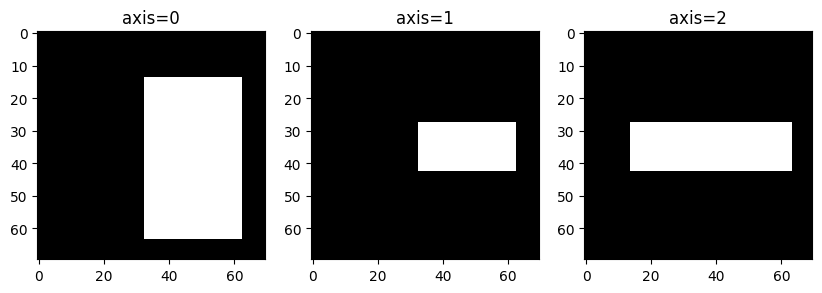

In [6]:
wannabe_napari(data_binary)
# view_napari(data_binary, "Original")

Then, create a **realistic** synthetic rectangular prism. Here, realistic refers to the fact that the background is not zero and the volume is nonbinary:

In [7]:
def create_rectangular_prism_realistic(lengths, offsets, grid_size):
    # Initialize a grid with a faint background
    grid = 10 * np.ones((grid_size[0], grid_size[1], grid_size[2]), dtype=np.uint8)

    # Define the starting point
    x_start, y_start, z_start = offsets

    # Fill in the grid cells corresponding to the rectangular prism with 200
    x_len, y_len, z_len = lengths
    grid[
        x_start : x_start + x_len, y_start : y_start + y_len, z_start : z_start + z_len
    ] = 200

    return grid


lengths = (15, 50, 30)
offsets = np.array((8, -6, 13)) + np.array((20, 20, 20))
grid_size = np.asarray((70, 70, 70))

data_realistic = create_rectangular_prism_realistic(lengths, offsets, grid_size)


View:

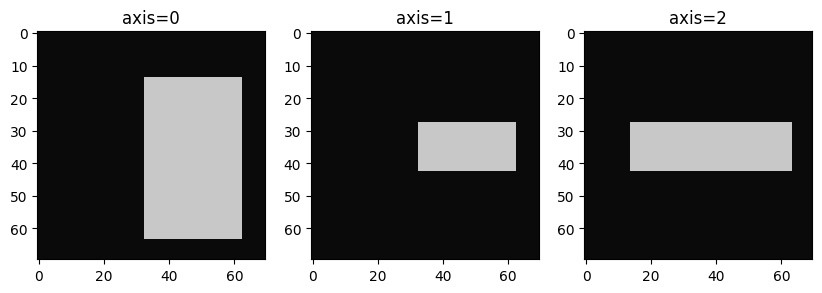

In [8]:
wannabe_napari(data_realistic)
# view_napari(data_realistic, "Original")

### Rotate the prism

Apply two arbitrary rotations to the prism.

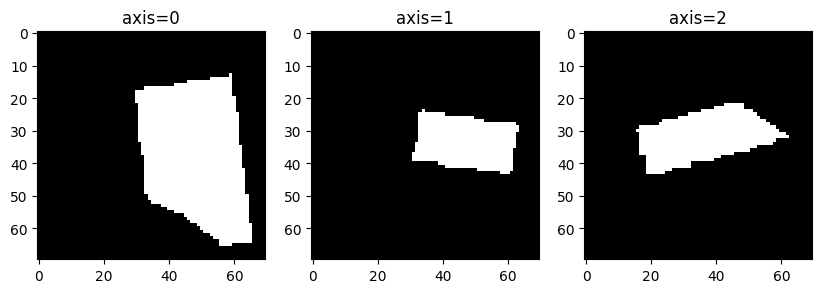

In [9]:
def rotation_matrix(axis, theta_degrees):
    axis = axis / np.sqrt(np.dot(axis, axis))
    return R.from_rotvec(theta_degrees * axis, degrees=True).as_matrix()


def rotate_volume(volume, axis, theta_degrees):
    # Create a rotation matrix from the axis and angle
    rot_mat = rotation_matrix(axis, theta_degrees)

    # Apply the rotation to the prism grid
    rotated_volume = affine_transform(volume, rot_mat.T, output_shape=grid_size)

    return rotated_volume


# ROTATION 1
# Create a random rotation matrix
axis = np.array([1, 1, 2])
theta_degrees = 10
rotated_prism_binary = rotate_volume(data_binary, axis, theta_degrees)

# ROTATION 2
# Create a random rotation matrix
axis = np.array([3.2, 3.9, 5.1])
theta_degrees = 9
rotated_prism_binary = rotate_volume(rotated_prism_binary, axis, theta_degrees)

# View
wannabe_napari(rotated_prism_binary)
# view_napari(rotated_prism_binary, "Rotated volume")


### Prismatic alignment

Now, the meat of it -- let's try to align the prism.

Check out [this post](https://alyssaq.github.io/2015/computing-the-axes-or-orientation-of-a-blob/) for more info on the two primary methods: covariance matrix vs. image moments. Covariance matrix is both slower and requires an initial segmentation, so image moments are preferred.

[This post](http://raphael.candelier.fr/?blog=Image%20Moments) was also very nice.

In [10]:
def find_orientation(prism):
    # If needed, segment the prism from the background for moments calculation
    if prism.max() > 1:
        print("Applying binary segmentation")
        prism = np.asarray(prism > 50, dtype=np.uint8)

    # Calculate second-order moments
    M = measure.moments_central(prism, order=2)

    # Constructing the covariance matrix from the central moments
    cov_matrix = np.array(
        [
            [M[2, 0, 0], M[1, 1, 0], M[1, 0, 1]],
            [M[1, 1, 0], M[0, 2, 0], M[0, 1, 1]],
            [M[1, 0, 1], M[0, 1, 1], M[0, 0, 2]],
        ]
    )

    # Compute eigenvectors from the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Print the results
    print("Moments:\n", M)
    print("Eigenvalues:\n", eigenvalues)
    print("Eigenvectors:\n", eigenvectors)

    return eigenvectors

Create `rotate_to_align`` function where we apply the affine transform:

In [11]:
def rotate_to_align(prism):
    # Calculate orientation matrix using moments method
    orientation_matrix = find_orientation(prism)

    # Rotate the prism using the orientation matrix
    aligned_prism = affine_transform(prism, orientation_matrix.T, order=3)

    return aligned_prism

Align the prism:

Moments:
 [[[  22478.               0.         1738672.33779696]
  [      0.          503797.36008542       0.        ]
  [4346179.89233918       0.               0.        ]]

 [[      0.           50326.58830857       0.        ]
  [-997531.51392473       0.               0.        ]
  [      0.               0.               0.        ]]

 [[ 701112.34344693       0.               0.        ]
  [      0.               0.               0.        ]
  [      0.               0.               0.        ]]]
Eigenvalues:
 [4678447.69834513  422109.62274801 1685407.25248992]
Eigenvectors:
 [[-0.23822595  0.95582675  0.17217321]
 [ 0.95792561  0.26046636 -0.1205645 ]
 [ 0.1600841  -0.13620754  0.97766077]]


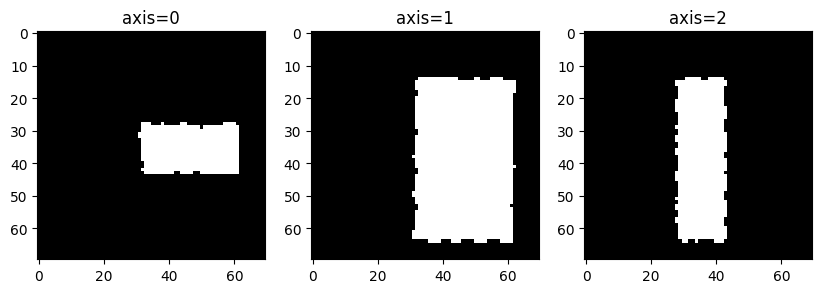

In [12]:
aligned_prism = rotate_to_align(rotated_prism_binary)

wannabe_napari(aligned_prism)
# view_napari(aligned_prism, "Aligned volume")

This works great! There's some noise at the edges from interpolation, but that's to be expected.

### Putting it all together (successful case 1)
Below, I've put it all together to summarize.

Moments:
 [[[  22478.               0.         1738672.33779696]
  [      0.          503797.36008542       0.        ]
  [4346179.89233918       0.               0.        ]]

 [[      0.           50326.58830857       0.        ]
  [-997531.51392473       0.               0.        ]
  [      0.               0.               0.        ]]

 [[ 701112.34344693       0.               0.        ]
  [      0.               0.               0.        ]
  [      0.               0.               0.        ]]]
Eigenvalues:
 [4678447.69834513  422109.62274801 1685407.25248992]
Eigenvectors:
 [[-0.23822595  0.95582675  0.17217321]
 [ 0.95792561  0.26046636 -0.1205645 ]
 [ 0.1600841  -0.13620754  0.97766077]]


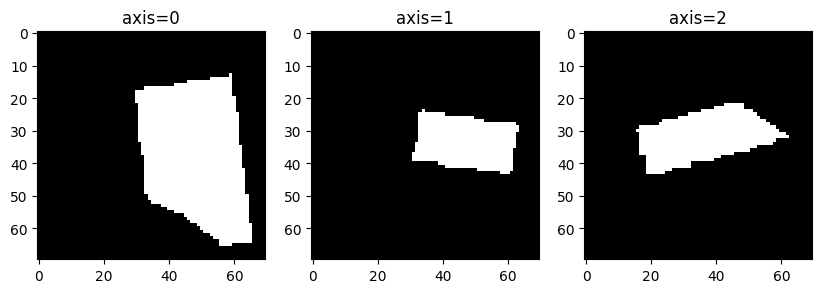

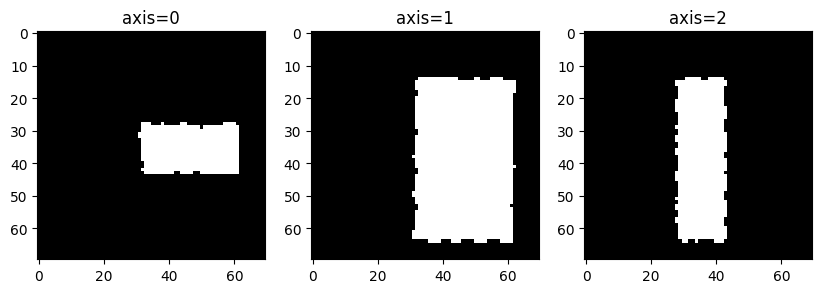

In [13]:
# ROTATION 1
# Create a random rotation matrix
axis = np.array([1, 1, 2])
theta_degrees = 10
rotated_prism_binary = rotate_volume(data_binary, axis, theta_degrees)

# ROTATION 2
# Create a random rotation matrix
axis = np.array([3.2, 3.9, 5.1])
theta_degrees = 9
rotated_prism_binary = rotate_volume(rotated_prism_binary, axis, theta_degrees)

# View original
wannabe_napari(rotated_prism_binary)
# view_napari(rotated_prism, "Rotated volume")

# Align
aligned_prism = rotate_to_align(rotated_prism_binary)

# View aligned
wannabe_napari(aligned_prism)
# view_napari(aligned_prism, "Aligned volume")

Again, the images are aligned as expected.

### Unsuccessful case 1: Second rotation angle changes from 9 to 8
Unfortunately, I can't replicate this success on a very similar test case:

Moments:
 [[[  22463.               0.         1728738.66028581]
  [      0.          473944.84521212       0.        ]
  [4368805.28932022       0.               0.        ]]

 [[      0.           51251.2025108        0.        ]
  [-952138.30374393       0.               0.        ]
  [      0.               0.               0.        ]]

 [[ 673865.9472911        0.               0.        ]
  [      0.               0.               0.        ]
  [      0.               0.               0.        ]]]
Eigenvalues:
 [4668304.27000942  422213.30522802 1680892.32165969]
Eigenvectors:
 [[ 0.22737077 -0.96060784  0.15979708]
 [-0.96200793 -0.24703915 -0.11624283]
 [-0.15113991  0.12729584  0.98028185]]


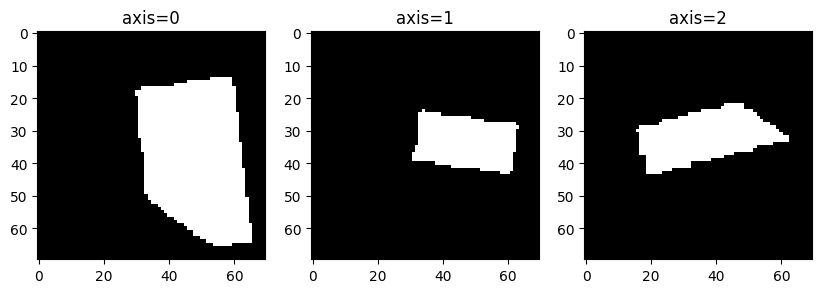

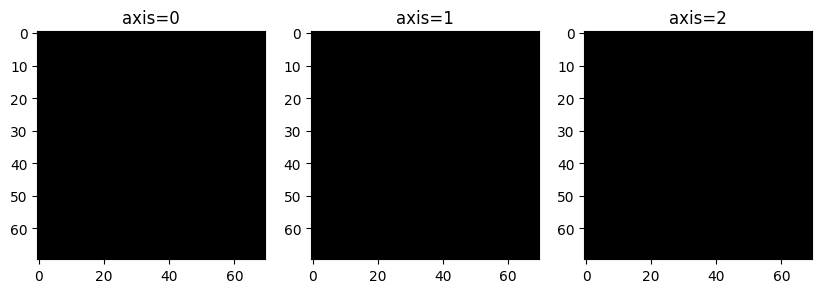

In [14]:
# ROTATION 1
# Create a random rotation matrix
axis = np.array([1, 1, 2])
theta_degrees = 10
rotated_prism_binary = rotate_volume(data_binary, axis, theta_degrees)

# ROTATION 2
# Create a random rotation matrix
axis = np.array([3.2, 3.9, 5.1])
theta_degrees = 8  # CHANGED FROM 9 TO 8
rotated_prism_binary = rotate_volume(rotated_prism_binary, axis, theta_degrees)

# View original
wannabe_napari(rotated_prism_binary)
# view_napari(rotated_prism, "Rotated volume")

# Align
aligned_prism = rotate_to_align(rotated_prism_binary)

# View aligned
wannabe_napari(aligned_prism)
# view_napari(aligned_prism, "Aligned volume")

I end up with nothing.

### Unsuccessful case 2: Second rotation angle changes from 9 to 10
Changing the second rotation angle from 9 to 10 also doesn't work:

Moments:
 [[[   22463.                0.          1746855.29510751]
  [       0.           533467.41508258        0.        ]
  [ 4313236.34367627        0.                0.        ]]

 [[       0.            44386.76565908        0.        ]
  [-1035611.79076704        0.                0.        ]
  [       0.                0.                0.        ]]

 [[  724533.30872991        0.                0.        ]
  [       0.                0.                0.        ]
  [       0.                0.                0.        ]]]
Eigenvalues:
 [4677486.6887037   421247.59401499 1685890.664795  ]
Eigenvectors:
 [[ 0.24796339 -0.95164571  0.1813411 ]
 [-0.95376203 -0.27262756 -0.12653933]
 [-0.16985919  0.14157914  0.9752452 ]]


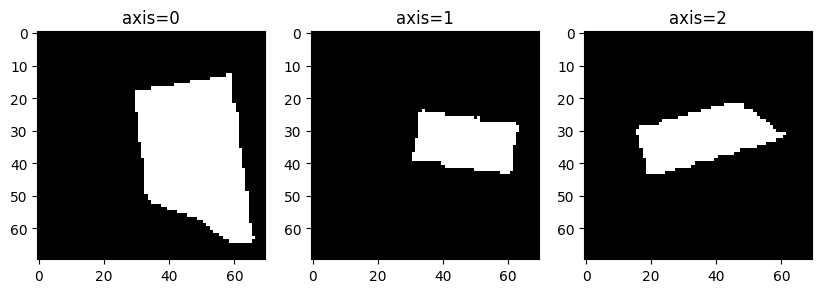

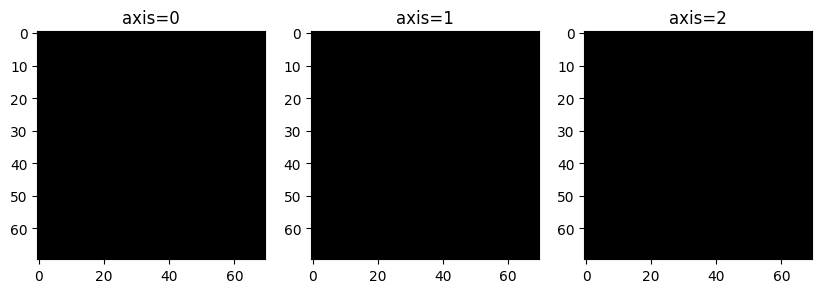

In [15]:
# ROTATION 1
# Create a random rotation matrix
axis = np.array([1, 1, 2])
theta_degrees = 10
rotated_prism_binary = rotate_volume(data_binary, axis, theta_degrees)

# ROTATION 2
# Create a random rotation matrix
axis = np.array([3.2, 3.9, 5.1])
theta_degrees = 10  # CHANGED FROM 9 TO 10
rotated_prism_binary = rotate_volume(rotated_prism_binary, axis, theta_degrees)

# View original
wannabe_napari(rotated_prism_binary)
# view_napari(rotated_prism, "Rotated volume")

# Align
aligned_prism = rotate_to_align(rotated_prism_binary)

# View aligned
wannabe_napari(aligned_prism)
# view_napari(aligned_prism, "Aligned volume")

Again, I end up with nothing visible.

### Unsuccessful case 3: Use realistic volume
Finally, I tried using the realistic volume with `9`, but it also doesn't work:

Applying binary segmentation
Moments:
 [[[   24170.                0.          1941856.80467522]
  [       0.           555108.41497725        0.        ]
  [ 4788514.62143153        0.                0.        ]]

 [[       0.            53617.68518825        0.        ]
  [-1091531.68638808        0.                0.        ]
  [       0.                0.                0.        ]]

 [[  794742.19648324        0.                0.        ]
  [       0.                0.                0.        ]
  [       0.                0.                0.        ]]]
Eigenvalues:
 [5153260.18054032  490123.70053717 1881729.7415125 ]
Eigenvectors:
 [[ 0.23787079 -0.95609775  0.17115661]
 [-0.95776222 -0.26020045 -0.12242247]
 [-0.16158287  0.1348066   0.97760839]]


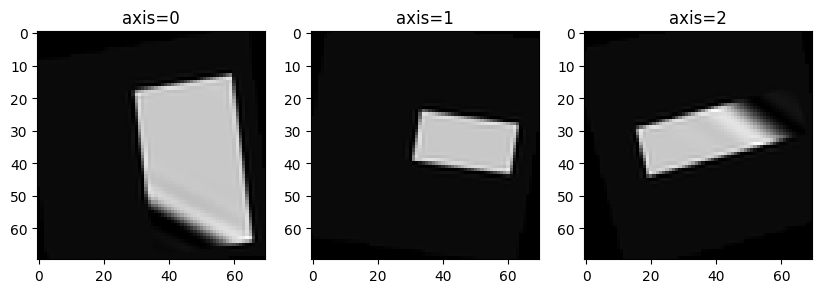

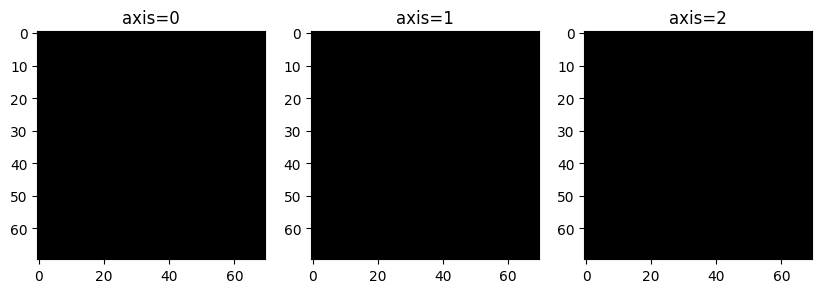

In [16]:
# ROTATION 1
# Create a random rotation matrix
axis = np.array([1, 1, 2])
theta_degrees = 10
rotated_prism_realistic = rotate_volume(data_realistic, axis, theta_degrees)

# ROTATION 2
# Create a random rotation matrix
axis = np.array([3.2, 3.9, 5.1])
theta_degrees = 9
rotated_prism_realistic = rotate_volume(rotated_prism_realistic, axis, theta_degrees)

# View original
wannabe_napari(rotated_prism_realistic)
# view_napari(rotated_prism_realistic, "Rotated volume")

# Align
aligned_prism = rotate_to_align(rotated_prism_realistic)

# View aligned
wannabe_napari(aligned_prism)
# view_napari(aligned_prism, "Aligned volume")

# Conclusions

I'm pretty confused as to why this function is so sensitive.